In [1]:
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
torch.__version__

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# 1. Get data ready

In [158]:
# lets take 2000 samples
n_samples = 2000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03, # add some noise to data
                    random_state=42)

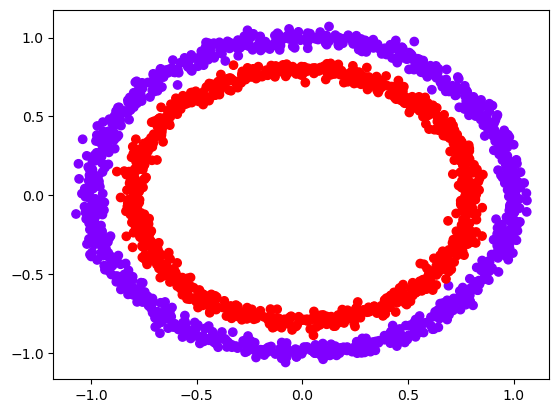

In [87]:
# lets try to visualise the data
plt.scatter(X[:,0], X[:,1], c = y, cmap="rainbow")

Therefore, our aim is to separate thhese two circles and therefore to compute to which circle the data (coordinates) belongs to

In [159]:
# convert to tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [160]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=42,
                                                    test_size=0.2)

# change device of data
X_train, y_train = X_train.to(device), y_train.unsqueeze(dim=1).to(device)
X_test, y_test = X_test.to(device), y_test.unsqueeze(dim=1).to(device)

# 2. Build a model
a. construct a model\
b. define a loss function\
c. define an optimiser\
d. creating a training and test loop

In [190]:
# construct a model
class circle_model(nn.Module):
    def __init__(self):
        super().__init__()

        # create 2 linear layers capable of handling the data
        self.layer1 = nn.Linear(in_features=2, out_features=8, bias =True)
        self.act1 = nn.ReLU() # impart non linearity
        self.layer2 = nn.Linear(in_features=8, out_features=1, bias=True)

    def forward(self, x):
        return self.layer2(self.act1(self.layer1(x)))

# instantiate model and send to gpu
model_0 = circle_model().to(device)

In [38]:
# same as above in easier way
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=8, bias =True),
#     nn.Linear(in_features=1, out_features=1, bias =True)
# ).to(device= device)

Lets use binary cross entropy loss function with logits and then use Adam optimizer which is the most commonly used optimiser.

In [191]:
loss_fn = nn.BCEWithLogitsLoss() # has sigmoid activation function built-in

optim = torch.optim.Adam(params=model_0.parameters(),
                        lr = 0.1)

if BCE loss was used, for forward pass, we need to do, `torch.sigmoid` for the predictions to convert logits to probabilities.

Also note that, for binary prediction we need to `round off`. For mulitclass prediction (after softmax), we need to do `torch.argmax` to compute the loss.

In [66]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # computes element wise equality
    return (correct/len(y_pred))*100

# 3. Training
a. forward pass\
b. calcuate loss\
c. optimiser zero grad\
d. loss backward\
e. optimiser step (GD)

In [192]:
epochs = 100

torch.cuda.manual_seed(42)

for epoch in range(epochs):

    # initiate training
    model_0.train()

    # a. forward pass
    y_logits = model_0(X_train) 

    # b. loss function
    loss = loss_fn(y_logits, y_train) # since with logits, expects logits as input as it computes the sigmoid on its own

    # c. optimiser zero grad
    optim.zero_grad()

    # d. loss backward
    loss.backward()

    # e. optimiser step
    optim.step()

    ### testing ###
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test)
    
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy(y_true= y_test, y_pred= test_pred)

    if epoch %10 ==0 or epochs<=10:
        print(f"epoch : {epoch} | train loss : {loss.cpu()}, | test loss : {test_loss} | validation score : {test_acc:.2f}")

epoch : 0 | train loss : 0.6980449557304382, | test loss : 0.702051043510437 | validation score : 50.00
epoch : 10 | train loss : 0.6535406112670898, | test loss : 0.6563459038734436 | validation score : 56.75
epoch : 20 | train loss : 0.5233245491981506, | test loss : 0.508367121219635 | validation score : 87.00
epoch : 30 | train loss : 0.31882163882255554, | test loss : 0.3035147488117218 | validation score : 98.00
epoch : 40 | train loss : 0.15039555728435516, | test loss : 0.14138631522655487 | validation score : 100.00
epoch : 50 | train loss : 0.06756475567817688, | test loss : 0.06605282425880432 | validation score : 100.00
epoch : 60 | train loss : 0.038120828568935394, | test loss : 0.03828532621264458 | validation score : 100.00
epoch : 70 | train loss : 0.02560732699930668, | test loss : 0.02532869577407837 | validation score : 100.00
epoch : 80 | train loss : 0.019596025347709656, | test loss : 0.01939086616039276 | validation score : 100.00
epoch : 90 | train loss : 0.016

In [145]:
# plotting function from github
import requests
from pathlib import Path

if Path("./ext_fns/helper_functions.py").is_file(): print("file already exists")
else:
    print("loading the python file")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    if not Path("./ext_fns").exists(): Path("ext_fns").mkdir(parents=True)
    with open("./ext_fns/helper_functions.py", "wb") as f:
        f.write(request.content)

loading the python file


In [111]:
from ext_fns.helper_functions import plot_predictions, plot_decision_boundary

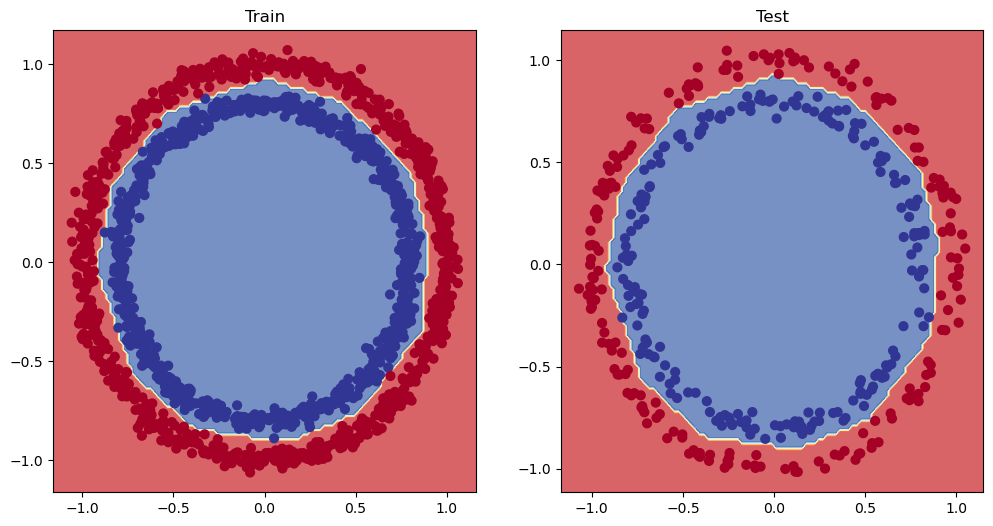

In [207]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Putting all together for a multiclass classfication problem

In [3]:
from sklearn.datasets import make_blobs # blobs dataset

In [81]:
# load data
n_classes = 4   # number of centers
n_features = 2
random_seed = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=n_features,
                            centers=n_classes, cluster_std=2.5,
                            random_state=random_seed)

# data to tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [82]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2,
                                                    random_state=random_seed)

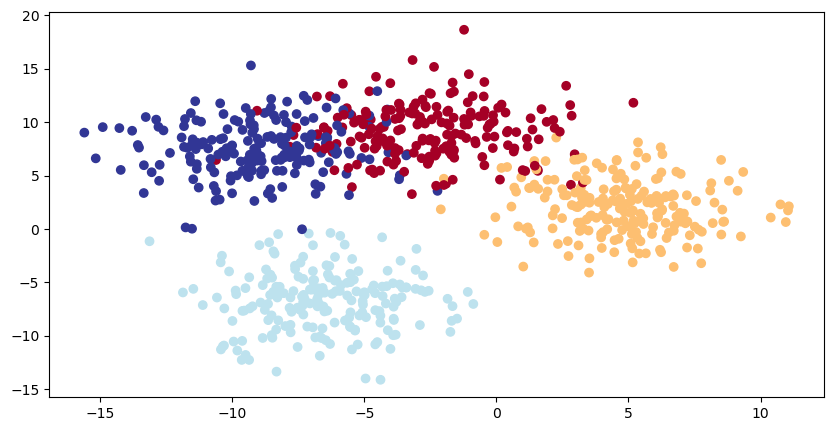

In [83]:
# plot data
plt.figure(figsize=(10,5))
plt.scatter(X_train[:,0],  X_train[:,1], c = y_train, cmap=plt.cm.RdYlBu)

In [133]:
# training
# we require 4 label classficiation model

class blob_model(nn.Module):

    def __init__(self, inp_features, out_features, hidden_units=8):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(nn.Linear(in_features=inp_features, out_features=hidden_units),
                                                nn.Linear(in_features=hidden_units, out_features=hidden_units),
                                                nn.Linear(in_features=hidden_units, out_features=out_features))

    def forward(self, x):
        return self.linear_layer_stack(x)

In [85]:
n_out_features = len(torch.unique(y_train))  # number of output features. same as n_classes
n_out_features

4

In [134]:
# create an instance
model_blob = blob_model(inp_features=n_features,
                        out_features= n_out_features,
                        hidden_units=8).to(device)

In [135]:
# create loss function
loss_fn = nn.CrossEntropyLoss()

# optimiser
optim = torch.optim.SGD(params=model_blob.parameters(),
                        lr=0.1)

In [136]:
with torch.inference_mode():
    y_logits = model_blob(X_train.to(device)) # prediction

yy = torch.softmax(y_logits, dim=1) # softmax to get probability

y_preds = torch.argmax(yy, axis=1) 

acc = (y_preds== y_train.to(device)).sum()/len(y_train.to(device))*100 # accuracy before training
acc

tensor(61.3750, device='cuda:0')

In [137]:
# training
torch.manual_seed(42)

epochs = 500

# data to gpu
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    # training
    model_blob.train()

    y_logits = model_blob(X_train)
    y_pred   = torch.softmax(y_logits, dim=1).argmax(dim=1) # just the argmax is enough, will get the same result

    loss = loss_fn(y_logits, y_train)

    acc = accuracy(y_true=y_train, y_pred=y_pred)

    optim.zero_grad()

    loss.backward()

    optim.step()

    # testing
    model_blob.eval()

    with torch.inference_mode():
        test_logits = model_blob(X_test)

        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy(y_true=y_test, y_pred= test_preds)

    if epoch % 100 == 0 or epochs <= 10:
        print(f"Epoch: {epoch} | Training Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")

Epoch: 0 | Training Loss: 1.0631, Acc: 61.38% | Test Loss: 0.6210, Acc: 87.50%
Epoch: 100 | Training Loss: 0.1863, Acc: 92.25% | Test Loss: 0.1628, Acc: 93.50%
Epoch: 200 | Training Loss: 0.2001, Acc: 91.50% | Test Loss: 0.1452, Acc: 94.00%
Epoch: 300 | Training Loss: 0.1718, Acc: 92.62% | Test Loss: 0.1354, Acc: 94.50%
Epoch: 400 | Training Loss: 0.1663, Acc: 93.25% | Test Loss: 0.1276, Acc: 96.00%


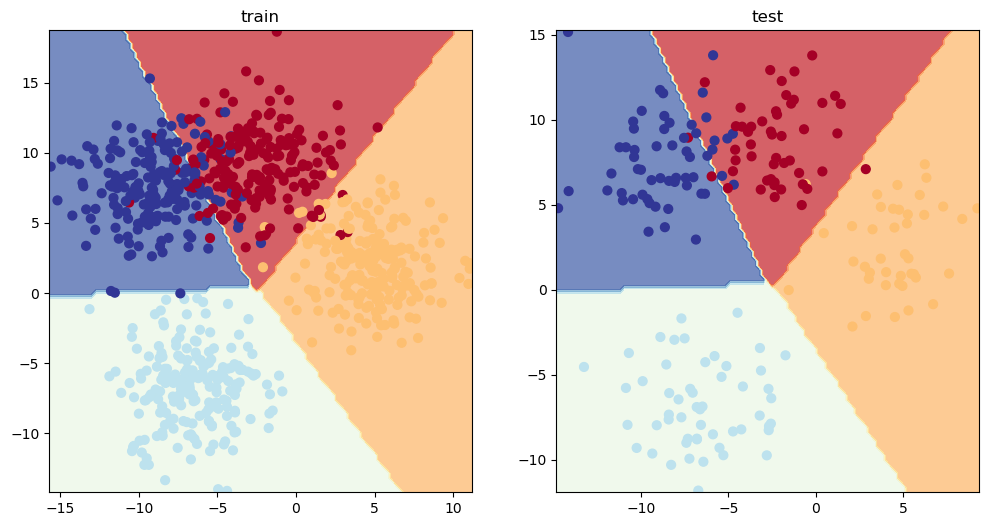

In [138]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model=model_blob, X=X_train, y=y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model=model_blob, X=X_test, y=y_test)

In [169]:
# giving non linearity

class blob_model(nn.Module):

    def __init__(self, inp_features, out_features, hidden_units=8):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(nn.Linear(in_features=inp_features, out_features=hidden_units),
                                                nn.ReLU(),
                                                nn.Linear(in_features=hidden_units, out_features=hidden_units),
                                                nn.ReLU(),
                                                nn.Linear(in_features=hidden_units, out_features=out_features))

    def forward(self, x):
        return self.linear_layer_stack(x)

In [171]:
# create an instance
model_blob = blob_model(inp_features=n_features,
                        out_features= n_out_features,
                        hidden_units=8).to(device)

In [172]:
# create loss function
loss_fn = nn.CrossEntropyLoss()

# optimiser
optim = torch.optim.SGD(params=model_blob.parameters(),
                        lr=0.1)

In [173]:
# training
torch.manual_seed(42)

epochs = 1000

# data to gpu
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    # training
    model_blob.train()

    y_logits = model_blob(X_train)
    y_pred   = torch.softmax(y_logits, dim=1).argmax(dim=1) # just the argmax is enough, will get the same result

    loss = loss_fn(y_logits, y_train)

    acc = accuracy(y_true=y_train, y_pred=y_pred)

    optim.zero_grad()

    loss.backward()

    optim.step()

    # testing
    model_blob.eval()

    with torch.inference_mode():
        test_logits = model_blob(X_test)

        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy(y_true=y_test, y_pred= test_preds)

    if epoch % 100 == 0 or epochs <= 10:
        print(f"Epoch: {epoch} | Training Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")

Epoch: 0 | Training Loss: 1.4821, Acc: 25.12% | Test Loss: 1.4028, Acc: 24.50%
Epoch: 100 | Training Loss: 0.2002, Acc: 91.62% | Test Loss: 0.1678, Acc: 93.50%
Epoch: 200 | Training Loss: 0.1870, Acc: 92.38% | Test Loss: 0.1563, Acc: 93.50%
Epoch: 300 | Training Loss: 0.1799, Acc: 92.75% | Test Loss: 0.1501, Acc: 93.50%
Epoch: 400 | Training Loss: 0.1748, Acc: 92.75% | Test Loss: 0.1457, Acc: 93.50%
Epoch: 500 | Training Loss: 0.1707, Acc: 93.00% | Test Loss: 0.1421, Acc: 93.50%
Epoch: 600 | Training Loss: 0.1670, Acc: 93.12% | Test Loss: 0.1394, Acc: 94.50%
Epoch: 700 | Training Loss: 0.1641, Acc: 93.12% | Test Loss: 0.1369, Acc: 94.50%
Epoch: 800 | Training Loss: 0.1621, Acc: 93.38% | Test Loss: 0.1386, Acc: 93.50%
Epoch: 900 | Training Loss: 0.1608, Acc: 93.25% | Test Loss: 0.1386, Acc: 94.00%


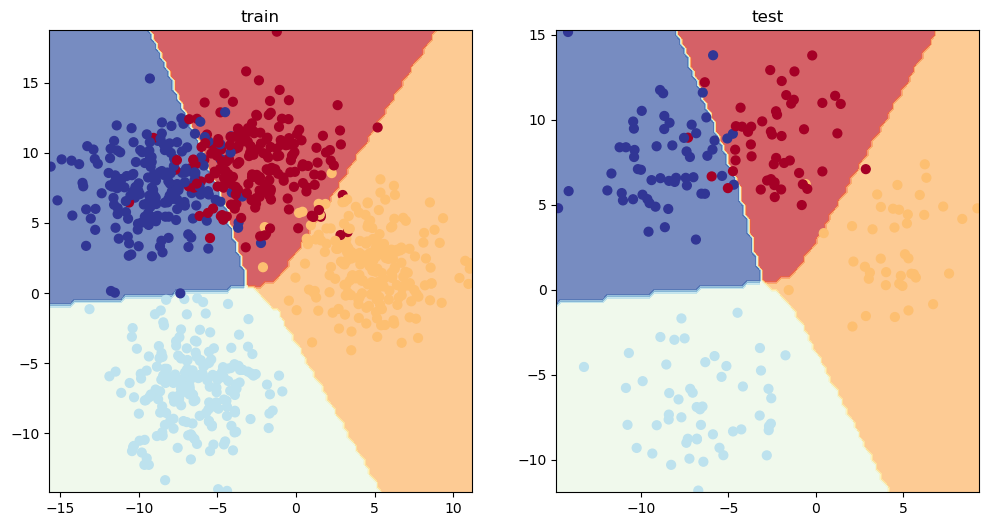

In [174]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model=model_blob, X=X_train, y=y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model=model_blob, X=X_test, y=y_test)

In this case, we can see that the linear classification is better compared to non linear. We can imrove the accuracy using more number of features and using different type of optimisers.